In [118]:
import networkx as nx
import utils
import time
import matplotlib.pyplot as plt
import pandas as pd
import Graph_Exploration
import pickle
import Louvain_algo
from cdlib import algorithms
import numpy as np
import random
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score

Load the graphs

In [2]:
def small_G():
    G = nx.Graph()

    # Add nodes
    G.add_node(1)
    G.add_nodes_from([1,2, 3, 4, 5, 6, 7, 8, 9])

    # Add edges
    G.add_edges_from([(1,2),(1, 3),(2,3), (3,6),(3,7),(3,9),(4,5),(4,7),(4,8),(5,7),(5,8),(6,9),(7,8),(8,9)])
    return G
small_graph = small_G()

In [3]:
def email():
    graph = nx.read_edgelist("data/email-Eu-core.txt", nodetype = int)
    s = list(nx.connected_components(graph))
    G = graph.subgraph(s[0])
    return G
email_graph = email()

In [4]:
def citation():
    graph = nx.read_edgelist("data/CA-GrQc.txt", nodetype = int)
    s = list(nx.connected_components(graph))
    G = graph.subgraph(s[0])
    return G
citation_graph = citation()

In [5]:
nodes,edges = utils.Load_data("nodes_with_all_communities.csv","edges without loops.csv")
facebook_graph = utils.Create_Graph(nodes=nodes , edges=edges)

Time mesurements

In [6]:

def louvain_built_time(G):
    start_time = time.time()
    communities_built = nx.community.louvain_communities(G)
    t = time.time()-start_time
    return t

In [91]:
graphs = [small_graph,email_graph,citation_graph,facebook_graph]

data_dict = {
    'names': ['small_graph','email_graph','citation_graph','facebook_graph'],
    'nodes': [G.number_of_nodes() for G in graphs],
    'edges': [G.number_of_edges() for G in graphs],
    'louvain_built_time': [louvain_built_time(G) for G in graphs]
}
data_dict

{'names': ['small_graph', 'email_graph', 'citation_graph', 'facebook_graph'],
 'nodes': [9, 986, 4158, 22470],
 'edges': [14, 16687, 13428, 170823],
 'louvain_built_time': [0.0005488395690917969,
  0.2472832202911377,
  0.34808802604675293,
  3.6674246788024902]}

In [8]:
def apply_own_time(G):
    start_time = time.time()
    algo = Louvain_algo.Louvain_algo(G)
    com = algo.run()
    t = time.time()-start_time
    return t

In [9]:
data_dict['own_time'] = []
for G in graphs:
    t = apply_own_time(G)
    data_dict['own_time'].append(t)

In [42]:
def apply_Leiden_time(G):
    start_time = time.time()
    coms = algorithms.leiden(G)
    coms = coms.communities
    t = time.time()-start_time
    return t

In [43]:
data_dict['leiden_time'] = []
for G in graphs:
    t = apply_Leiden_time(G)
    data_dict['leiden_time'].append(t)

Visualization runtime

In [104]:
data_dict

{'names': ['small_graph', 'email_graph', 'citation_graph', 'facebook_graph'],
 'nodes': [9, 986, 4158, 22470],
 'edges': [14, 16687, 13428, 170823],
 'louvain_built_time': [0.0005488395690917969,
  0.2472832202911377,
  0.34808802604675293,
  3.6674246788024902]}

In [29]:
def plot_G(x_axis,y1,y2,y3,title):
    plt.scatter(df[x_axis], df[y1])
    plt.scatter(df[x_axis], df[y2])
    plt.scatter(df[x_axis], df[y3])
    for i, txt in enumerate(df['names']):
        plt.annotate(txt, (df[x_axis][i], df[y2][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel(x_axis)
    plt.ylabel(y1)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

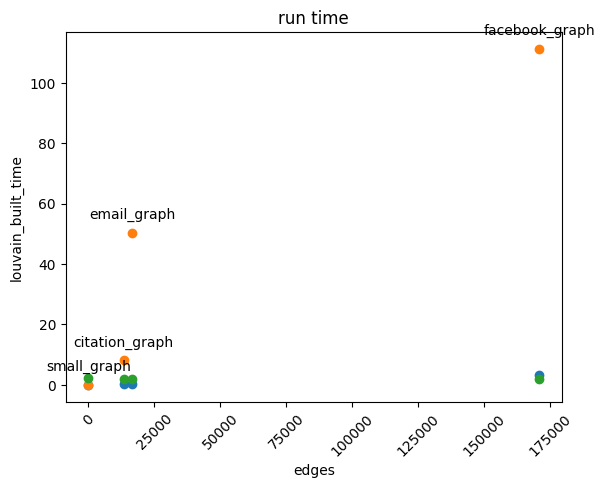

In [31]:
plot_G('edges','louvain_built_time','own_time','leiden_time','run time')

In [52]:
def plot_bar(y1,y2,y3,title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(4)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in data_dict.items():
        if attribute in [y1,y2,y3]:
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            #ax.bar_label(rects, padding=3)
            multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title)
    #ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width, data_dict['names'])
    ax.legend(loc='upper left', ncols=3)
    #ax.set_ylim(0, 200)

    plt.show()


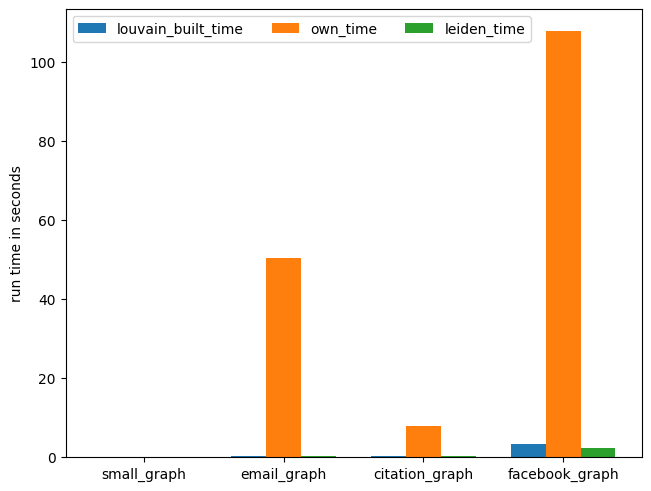

In [53]:
plot_bar('louvain_built_time','own_time','leiden_time','run time in seconds')


Get communities of other graphs

In [47]:
#Adding the community id to the graphs as attributes
def add_community_ids(G,node_lists,attribute):
    for i, nodes in enumerate(node_lists):
        for node in nodes:
            # Here you can set any attribute
            G.nodes[node][attribute] = i
    return G

In [48]:
def apply_own(G):
    algo = Louvain_algo.Louvain_algo(G)
    com = algo.run()
    return com
data_dict['num_own']=[]
for G in [small_graph,email_graph,citation_graph]:
    com = apply_own(G)
    data_dict['num_own'].append(len(com))
    G = add_community_ids(G,list(com.values()),'Louvain_id')

In [41]:
def louvain_built(G):
    communities_built = nx.community.louvain_communities(G)
    return communities_built
data_dict['num_built'] = []
for G in [small_graph,email_graph,citation_graph]:
    com = louvain_built(G)
    data_dict['num_built'].append(len(com))
    G = add_community_ids(G,com,'community_id')

In [61]:
def Leiden(G):
    communities_built = nx.community.louvain_communities(G)
    return communities_built
data_dict['num_leiden'] = []
for G in graphs:
    com = Leiden(G)
    data_dict['num_leiden'].append(len(com))
    G = add_community_ids(G,com,'Leiden_id')
data_dict['num_leiden']

[2, 9, 40, 56]

Cutsize

In [22]:
cutsizes = {}
cutsizes['built in'] = np.mean(list(Graph_Exploration.get_cut_sizes(facebook_graph,com_id="community_id").values()))
cutsizes['own Louvain'] = np.mean(list(Graph_Exploration.get_cut_sizes(facebook_graph,com_id="Louvain_id").values()))
cutsizes['Leiden'] = np.mean(list(Graph_Exploration.get_cut_sizes(facebook_graph,com_id="Leiden_id").values()))
cutsizes

{'built in': 694.8666666666667,
 'own Louvain': 638.2424242424242,
 'Leiden': 611.2537313432836}

{47: 5012, 10: 6485, 40: 239, 37: 5979, 33: 2135, 52: 105, 34: 1324, 43: 239, 54: 1068, 15: 137, 20: 3463, 0: 3647, 59: 864, 58: 480, 41: 499, 46: 147, 62: 186, 12: 1241, 11: 474, 63: 384, 36: 656, 28: 275, 35: 823, 25: 679, 4: 30, 32: 978, 19: 1513, 65: 432, 26: 353, 22: 316, 7: 236, 56: 35, 48: 160, 64: 180, 57: 65, 39: 215, 16: 60, 9: 220, 60: 43, 30: 246, 53: 29, 51: 88, 44: 47, 23: 66, 50: 32, 5: 9, 45: 74, 21: 25, 1: 30, 8: 3, 31: 4, 17: 1, 49: 31, 42: 4, 29: 13, 61: 3, 18: 3, 27: 20, 6: 2, 13: 2, 24: 9, 3: 1, 2: 1, 55: 2, 14: 1, 38: 1}


Text(0.5, 1.0, 'Cut size of Louvain communities')

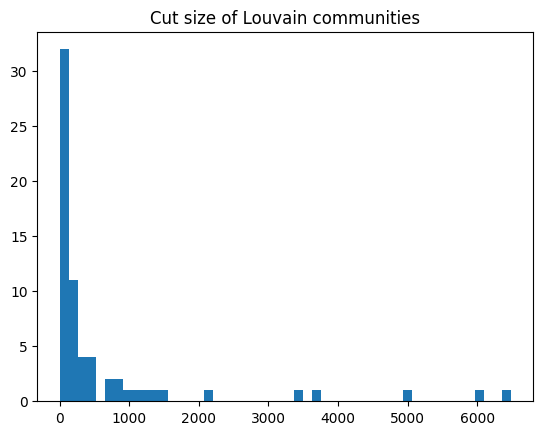

In [102]:
c = Graph_Exploration.get_cut_sizes(facebook_graph,com_id="Louvain_id")
print(c)
plt.hist(c.values(),bins = 50)
plt.title("Cut size of Louvain communities")

In [64]:
cutsize={}
cutsize['built_in'] = []
cutsize['own'] = []
cutsize['Leiden'] = []
for g in graphs:
    cutsize['built_in'].append(np.mean(list(Graph_Exploration.get_cut_sizes(g,com_id="community_id").values())))
    cutsize['own'].append(np.mean(list(Graph_Exploration.get_cut_sizes(g,com_id="Louvain_id").values())))
    cutsize['Leiden'].append(np.mean(list(Graph_Exploration.get_cut_sizes(g,com_id="Leiden_id").values())))
cutsize


{'built_in': [2.0, 1740.5, 70.15, 694.8666666666667],
 'own': [2.0, 1469.5, 73.45, 638.2424242424242],
 'Leiden': [2.0, 1479.7777777777778, 70.75, 746.3571428571429]}

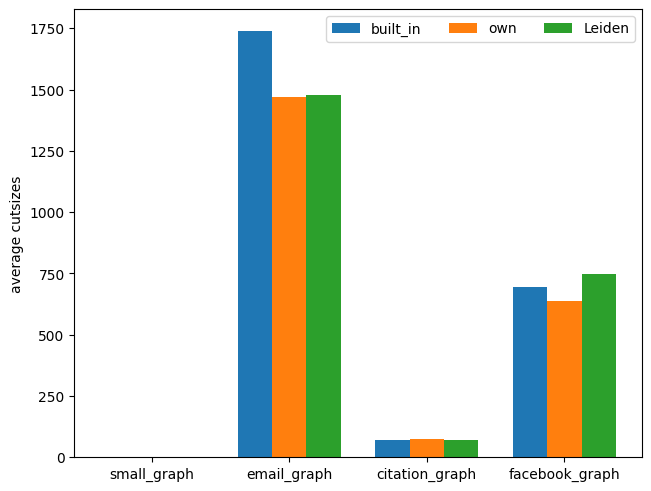

In [103]:
def plot_bar(title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(4)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in cutsize.items(): 
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title)
    #ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width, data_dict['names'])
    ax.legend(loc='upper right', ncols=3)
    #ax.set_ylim(0, 200)

    plt.show()
plot_bar('average cutsizes')


In [66]:
data_dict['cut_size_louvain_built'] = [np.mean(list(Graph_Exploration.get_cut_sizes(g,com_id="community_id"))) for g in graphs]
data_dict['cut_size_louvain_built'] 

[0.5, 3.5, 19.5, 30.5]

Modularity

In [83]:
def get_mod(G,c):
    node_list = {}
    for node, val in  nx.get_node_attributes(G,c).items():
        if val in node_list.keys():
            node_list[val].append(node)
        else:
            node_list[val] = [node]
    return nx.community.modularity(G,list(node_list.values()))
modularity = {}
modularity['louvain_built'] = []
modularity['own'] = []
modularity['Leiden'] = []
for g in graphs:
    modularity['louvain_built'].append(get_mod(g,"community_id"))
    modularity['own'].append(get_mod(g,'Louvain_id'))
    modularity['Leiden'].append(get_mod(g,'Leiden_id'))

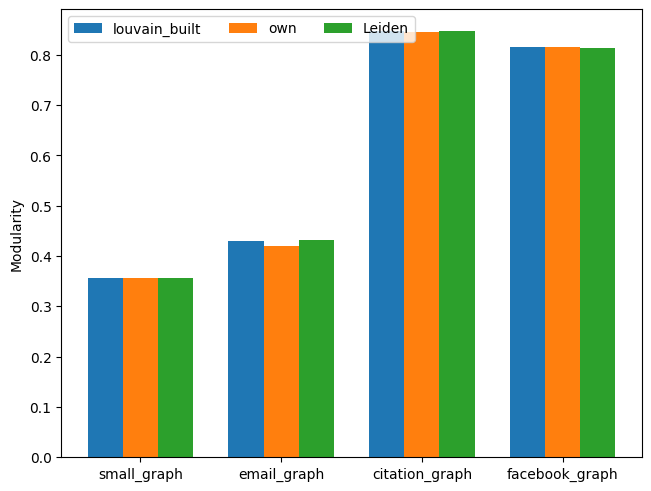

In [85]:
def plot_bar(title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(4)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in modularity.items(): 
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title)
    #ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width, data_dict['names'])
    ax.legend(loc='upper left', ncols=3)
    #ax.set_ylim(0, 200)

    plt.show()
plot_bar('Modularity')

In [15]:
data_dict['louvain_modularity'] = [nx.community.modularity(G,com) for G, com in zip(graphs,data_dict['louvain_built_in_n'])]
data_dict['louvain_modularity']

[0.35714285714285715,
 0.42900737746440626,
 0.8490340649085859,
 0.812893199816238]

Node type analysis

In [105]:
def get_assortativity(G):
    node_list = {}
    for node, val in  nx.get_node_attributes(G,'page_type').items():
        if val in node_list.keys():
            node_list[val].append(node)
        else:
            node_list[val] = [node]
    return nx.community.modularity(G,list(node_list.values()))
get_assortativity(facebook_graph)

0.5246338267609174

In [106]:
def get_random(G):
    node_list = {}
    for node  in  G.nodes():
        val = random.choice(["governement","Tv","company","polititian"])
        if val in node_list.keys():
            node_list[val].append(node)
        else:
            node_list[val] = [node]
    return nx.community.modularity(G,list(node_list.values()))
get_random(facebook_graph)

-0.00016397318202129862

In [138]:
def get_homogenity(G):
    page_types = {}
    for node, val in  nx.get_node_attributes(G,'page_type').items():
        if val in page_types.keys():
            page_types[val].append(node)
        else:
            page_types[val] = [node]
    communities = {}
    for node, val in  nx.get_node_attributes(G,'Louvain_id').items():
        if val in communities.keys():
            communities[val].append(node)
        else:
            communities[val] = [node]
    page_types = list(nx.get_node_attributes(G,'page_type').values())
    communities = list(nx.get_node_attributes(G,'Louvain_id').values())
    print(page_types)
    print(communities)
    print(completeness_score(page_types, communities))
    return homogeneity_score(page_types,communities)
get_homogenity(facebook_graph)
0.45535623624427823

['tvshow', 'government', 'company', 'government', 'politician', 'politician', 'politician', 'politician', 'government', 'government', 'government', 'politician', 'government', 'government', 'government', 'government', 'company', 'politician', 'government', 'company', 'politician', 'company', 'government', 'company', 'company', 'company', 'government', 'tvshow', 'company', 'company', 'company', 'government', 'government', 'politician', 'politician', 'company', 'company', 'government', 'government', 'government', 'politician', 'government', 'company', 'government', 'tvshow', 'company', 'politician', 'government', 'company', 'company', 'government', 'politician', 'tvshow', 'company', 'government', 'tvshow', 'government', 'company', 'government', 'politician', 'politician', 'company', 'politician', 'company', 'government', 'company', 'company', 'politician', 'tvshow', 'tvshow', 'tvshow', 'politician', 'government', 'politician', 'government', 'government', 'company', 'politician', 'politic

0.45535623624427823

In [135]:
from collections import Counter
def get_dist(G):
    com_0 = [] 
    for node, val in  nx.get_node_attributes(G,'Louvain_id').items():
        if val == 10:
            com_0.append(node)
    features = dict(nx.get_node_attributes(G,'page_type'))
    types = [features[n] for n in com_0]
    frequency = Counter(types)
    print(frequency)
get_dist(facebook_graph)

Counter({'government': 1098, 'company': 38, 'tvshow': 19, 'politician': 12})


Number of communities

In [87]:
def get_len(G,c):
    node_list = {}
    for node, val in  nx.get_node_attributes(G,c).items():
        if val in node_list.keys():
            node_list[val].append(node)
        else:
            node_list[val] = [node]
    return len(list(node_list.values()))
lengths = {}
lengths['louvain_built'] = []
lengths['own'] = []
lengths['Leiden'] = []
for g in graphs:
    lengths['louvain_built'].append(get_len(g,"community_id"))
    lengths['own'].append(get_len(g,'Louvain_id'))
    lengths['Leiden'].append(get_len(g,'Leiden_id'))

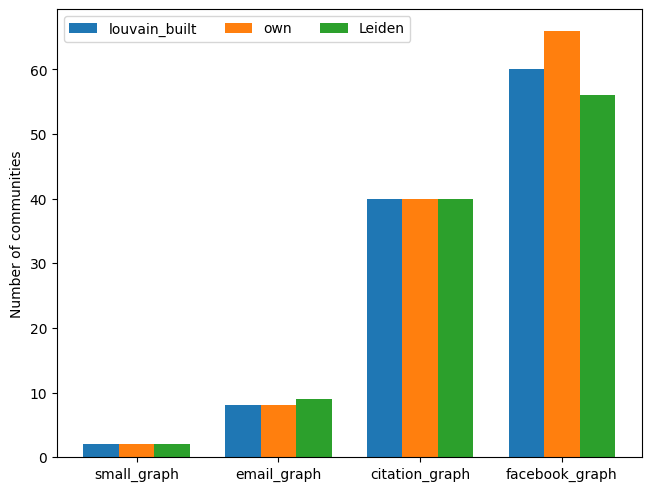

In [89]:
def plot_bar(title):
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(4)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in lengths.items(): 
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title)
    #ax.set_title('Penguin attributes by species')
    ax.set_xticks(x + width, data_dict['names'])
    ax.legend(loc='upper left', ncols=3)
    #ax.set_ylim(0, 200)

    plt.show()
plot_bar('Number of communities')

Analysis of page type

In [ ]:
facebook_graph

Add the own implementation

Plotting

In [20]:
df  =pd.DataFrame(data_dict)
df

,names,nodes,edges,louvain_built_time,louvain_built_in_n,cut_size_louvain_built,louvain_modularity,own_time,own_com
0,small_graph,9,14,0.000705,"[{1, 2, 3, 6, 9}, {8, 4, 5, 7}]",2.000000,0.357143,0.000502,None
1,email_graph,986,16687,0.249621,"[{0, 1, 519, 17, 18, 537, 560, 52, 60, 61, 73,...",1840.285714,0.429007,0.081822,None
2,citation_graph,4158,13428,0.347658,"[{3073, 25089, 22018, 13834, 17932, 11788, 261...",70.050000,0.849034,0.039836,None
3,facebook_graph,22470,170823,4.161697,"[{6404, 12041, 20746, 13327, 14352, 17425, 110...",713.366667,0.812893,0.061716,None


In [21]:
def plot_G(x_axis,y_axis,title):
    plt.scatter(df[x_axis], df[y_axis])
    for i, txt in enumerate(df['names']):
        plt.annotate(txt, (df[x_axis][i], df[y_axis][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

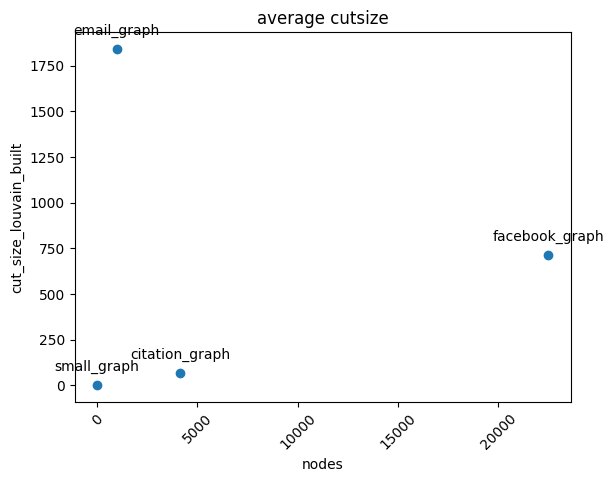

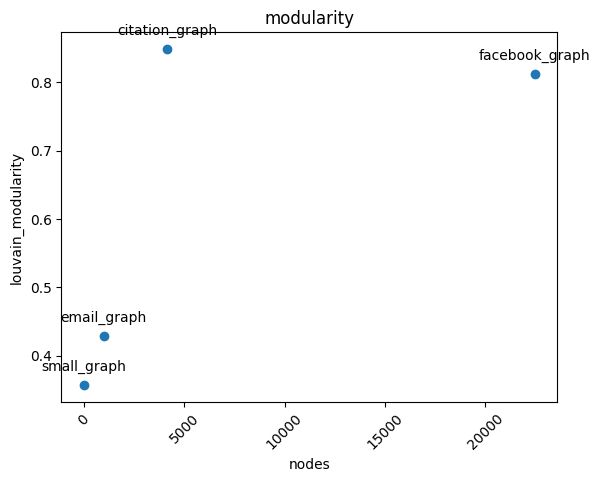

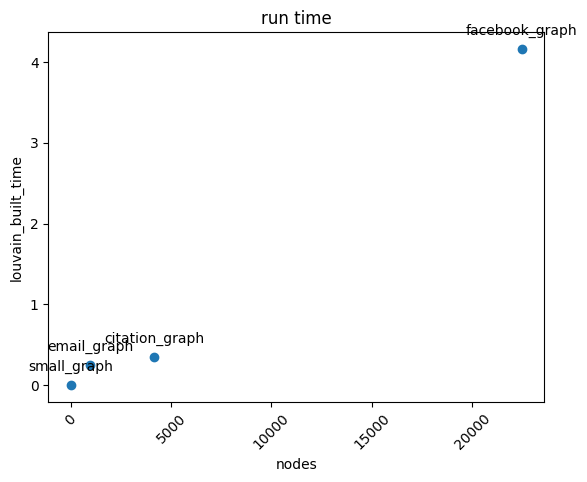

In [24]:
plot_G('nodes','cut_size_louvain_built','average cutsize')
plot_G('nodes','louvain_modularity','modularity')
plot_G('nodes','louvain_built_time','run time')

In [25]:
def apply_girvan_newman(G):
    start_time = time.time()
    girvan_newman = nx.community.girvan_newman(G)
    com = []
    old_mod = 0
    for level, comm_at_level in enumerate(girvan_newman):
        comm_at_level_sorted= sorted(comm_at_level, key=len, reverse=True)
        com.append(comm_at_level)
        new_mod = nx.community.modularity(G,comm_at_level_sorted)
        #print(new_mod)
        #print(com)
        if new_mod<(old_mod + 0.02):
            if new_mod<old_mod:
                best = -2
            else:
                best = -1
            break 
        old_mod = new_mod
        print([len(comm) for comm in comm_at_level_sorted])
        print(new_mod)
    t = time.time()-start_time
    return t,com[best]

In [26]:
t,com = apply_girvan_newman(small_graph)
print(t,com)

[5, 4]
0.35714285714285715
0.003760814666748047 ({1, 2, 3, 6, 9}, {8, 4, 5, 7})


In [27]:
data_dict['girvan_time'] = []
data_dict['girvan_com'] = []
for G in graphs:
    t,com = apply_girvan_newman(G)
    data_dict['girvan_time'].append(t)
    data_dict['girvan_com'].append(com)
    print("finished with",str(G))
    print("time",data_dict['girvan_time'])
    print("results",data_dict['girvan_com'])


[5, 4]
0.35714285714285715
finished with Graph with 9 nodes and 14 edges
time [0.003555774688720703]
results [({1, 2, 3, 6, 9}, {8, 4, 5, 7})]
finished with Graph with 986 nodes and 16687 edges
time [0.003555774688720703, 77.41249561309814]
results [({1, 2, 3, 6, 9}, {8, 4, 5, 7}), ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 

KeyboardInterrupt: 

In [62]:
def plot_Girvan(G):
    comm_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    pos = nx.spring_layout(G)
    node_sizes = [(G.degree(v))**2 / 10 for v in G]
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, node_size=node_sizes, width=0.025, node_color='tab:blue', edgecolors='k')
    plt.show()

    girvan_newman = nx.community.girvan_newman(G)

    for level, comm_at_level in enumerate(girvan_newman):
        comm_at_level_sorted = sorted(comm_at_level, key=len, reverse=True)
        print([len(comm) for comm in comm_at_level_sorted])
        
        node_colors = {}
        for comm_idx, community in enumerate(comm_at_level_sorted):
            for node in community:
                node_colors[node] = comm_colors[comm_idx%(len(comm_colors)-1)]

        if level % 5 == 4:
            plt.figure(figsize=(8, 5))
            nx.draw(G, pos, with_labels=False, node_size=node_sizes, width=0.025, node_color=[node_colors[node] for node in G.nodes], edgecolors='k')
            plt.show()

In [70]:
import itertools

k = 8

comp = nx.community.girvan_newman(email_graph)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)

for communities in limited:
    print(tuple(sorted(c) for c in communities))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221